In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test, ON_THRESHOLD
from sklearn.metrics import mean_absolute_error
import os
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../code/')
%matplotlib inline
import itertools
from pathlib import Path

In [2]:
def onoff_error(pred, gt, threshold):
    abs_error = np.abs(pred-gt)
    error = [x for x in abs_error.reshape(1, -1).tolist()[0] if x >= threshold]
    
    return np.mean(error)

In [3]:
tensor = np.load("../2015-5appliances.numpy.npy")
dr = tensor[:, 3]

In [4]:
# calculate gt
test_gt = {}
valid_gt = {}
for fold_num in range(5):
    test_gt[fold_num] = {}
    valid_gt[fold_num] = {}
    train, test = get_train_test(1, 5, fold_num)
    valid = train[int(0.8*len(train)):].copy()
    for idx, appliance in enumerate(APPLIANCE_ORDER[1:-1]):
        test_gt[fold_num][appliance] = test[:, idx+1]
        valid_gt[fold_num][appliance] = valid[:, idx+1]

In [5]:
threshold = {}
for fold_num in range(5):
    threshold[fold_num] = {}
    for appliance in ['hvac', 'fridge', 'dr', 'dw', 'mw']:
        
        sample_list = []
        for i in range(test_gt[fold_num][appliance].shape[0]):
            sample_list = np.append(sample_list, np.mean([x for x in test_gt[fold_num][appliance][i].reshape(1, -1).tolist()[0] if x > ON_THRESHOLD[appliance]]))
        threshold[fold_num][appliance] = 0.1*sample_list

/zf14/yj9xs/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/zf14/yj9xs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
def onoff_error(pred, gt, threshold):
    pred = pred.reshape(-1 ,112, 24)
    gt = gt.reshape(-1 ,112, 24)
    homes = pred.shape[0]
    error = {}
    abs_error = np.abs(pred-gt)
    if threshold == None:
        threshold = np.zeros(homes)
    for i in range(homes):
        error_list = [x for x in abs_error[i].reshape(1, -1)[0] if x >= threshold[i]]
        if len(error_list) == 0:
            error[i] = 0
        else:
            error[i] = np.mean([x for x in abs_error[i].reshape(1, -1)[0] if x >= threshold[i]])
#     print(abs_error[i])
#     print(threshold, error)
    
    
    return (pd.Series(error).mean())

In [7]:
def calculate_error(pred, gt, threshold):
    error = {}
    overall = {}
    num_homes = {}
    
    # calculte number of homes in each fold
    for fold_num in range(5):
        num_homes[fold_num] = gt[fold_num]['hvac'].reshape(-1, 1, 112,24).shape[0]
    homes = pd.Series(num_homes).sum()
    
    # for Constantly On appliances: hvac and fridge
#     for appliance in ['hvac', 'fridge']:
#         overall[appliance] = 0
#         error[appliance] = {}
#         for fold_num in range(5):
#             error[appliance][fold_num] = mean_absolute_error(pred[fold_num][appliance].reshape(-1, 24), 
#                                                              gt[fold_num][appliance].reshape(-1, 24))
#             overall[appliance] += error[appliance][fold_num]*num_homes[fold_num]
#         overall[appliance] /= homes
        
    # for ON/OFF appliances: dryer, dishwasher and microwave
    for appliance in ['hvac', 'fridge', 'dr', 'dw', 'mw']:
        error[appliance] = {}
        overall[appliance] = 0                                                                
        for fold_num in range(5):
            error[appliance][fold_num] = onoff_error(pred[fold_num][appliance].reshape(-1, 24), 
                                                     gt[fold_num][appliance].reshape(-1, 24), threshold[fold_num][appliance])
            overall[appliance] += error[appliance][fold_num]*num_homes[fold_num]
        overall[appliance] /= homes
    
    
    return error, overall

## stf

In [25]:
r = {}
mean_r = {}
for dataset in [1, 3]:
    r[dataset] = {}
    mean_r[dataset] = {}
    for cur_fold in range(5):
        r[dataset][cur_fold] = {}
        mean_r[dataset][cur_fold] = {}
        for num_latent in range(1, 21):
            r[dataset][cur_fold][num_latent] = {}
            mean_r[dataset][cur_fold][num_latent] = {}
            for lr in [0.01, 0.1 ,1 ,2]:
                lr = float(lr)
                r[dataset][cur_fold][num_latent][lr] = {}
                mean_r[dataset][cur_fold][num_latent][lr] = {}
                for iters in range(100, 2600, 400):
                    r[dataset][cur_fold][num_latent][lr][iters] = np.load("../code/baseline/stf/{}/valid/stf-pred-{}-{}-{}-{}-{}.npy".format(dataset, dataset, cur_fold, num_latent, lr, iters))
                    

In [26]:
np.save("../code/baseline/stf-valid-pred.npy", r)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [9]:
error = {}
best_p = {}
for dataset in [1, 3]:
    error[dataset] = {}
    best_p[dataset] = {}
    for cur_fold in range(5):
        error[dataset][cur_fold] = np.inf
        best_p[dataset][cur_fold] = {}
#         for idx, appliance in enumerate(APPLIANCE_ORDER[1:-1]):
#             error[dataset][cur_fold][appliance] = np.inf
#             best_p[dataset][cur_fold][appliance] = {}
#             if appliance in ['hvac', 'fridge']:
                
#                 for num_latent in range(1, 21):
#                     for lr in [0.01, 0.1, 1, 2]:
#                         for iters in range(100, 2600, 400):

#                             cur_error = mean_absolute_error(r[dataset][cur_fold][num_latent][lr][iters][:, idx].reshape(-1, 1), 
#                                                             valid_gt[cur_fold][appliance].reshape(-1, 1))
#                             if cur_error < error[dataset][cur_fold][appliance]:
#                                 error[dataset][cur_fold][appliance] = cur_error
#                                 best_p[dataset][cur_fold][appliance]['num_latent'] = num_latent
#                                 best_p[dataset][cur_fold][appliance]['lr'] = lr
#                                 best_p[dataset][cur_fold][appliance]['iters'] = iters
#             else:
        for num_latent in range(1, 21):
            for lr in [0.01, 0.1, 1, 2]:
                for iters in range(100, 2600, 400):
                    cur_error = 0
                    for idx, appliance in enumerate(APPLIANCE_ORDER[1:-1]):

                        cur_error += onoff_error(r[dataset][cur_fold][num_latent][lr][iters][:, idx].reshape(-1, 1), 
                                                        valid_gt[cur_fold][appliance].reshape(-1, 1), threshold[cur_fold][appliance])
                    if cur_error < error[dataset][cur_fold]:
                        error[dataset][cur_fold] = cur_error
                        best_p[dataset][cur_fold]['num_latent'] = num_latent
                        best_p[dataset][cur_fold]['lr'] = lr
                        best_p[dataset][cur_fold]['iters'] = iters

/zf14/yj9xs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  import sys


In [10]:
for dataset in [1, 3]:
    np.save("../code/baseline/result/stf-new-param-{}-per-home.npy".format(dataset), best_p[dataset])

In [11]:
for dataset in [1, 3]:
    for i in range(5):
        print("python baseline-stf-nested.py {} {} {} {} {} &".format(dataset, i, best_p[dataset][i]['num_latent'],
                                                                     best_p[dataset][i]['lr'],
                                                                     best_p[dataset][i]['iters']))

python baseline-stf-nested.py 1 0 19 2 1300 &
python baseline-stf-nested.py 1 1 19 1 500 &
python baseline-stf-nested.py 1 2 19 2 900 &
python baseline-stf-nested.py 1 3 18 2 1700 &
python baseline-stf-nested.py 1 4 17 2 2100 &
python baseline-stf-nested.py 3 0 20 1 500 &
python baseline-stf-nested.py 3 1 20 2 100 &
python baseline-stf-nested.py 3 2 20 1 2500 &
python baseline-stf-nested.py 3 3 20 2 500 &
python baseline-stf-nested.py 3 4 16 2 100 &


In [22]:
dataset = 3

In [23]:
# get prediction for cnn individual
stf_pred = {}
for fold_num in range(5):
    stf_pred[fold_num] = {}
#     for appliance in ['hvac', 'fridge', 'dr', 'dw', 'mw']:
        
    num_latent = best_p[dataset][fold_num]['num_latent']
    lr = float(best_p[dataset][fold_num]['lr'])
    iters = best_p[dataset][fold_num]['iters']

    result = np.load("../code/baseline/stf/{}/test/stf-test-pred-{}-{}-{}-{}-{}.npy".format(dataset, dataset, fold_num, num_latent, lr, iters))
    for idx, appliance in enumerate(APPLIANCE_ORDER[1:-1]): 
        stf_pred[fold_num][appliance] = result[:, idx]


In [24]:
pd.Series(calculate_error(stf_pred, test_gt, threshold)[1])

/zf14/yj9xs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  import sys


dr        674.064371
dw        191.479211
fridge     48.902483
hvac      484.900682
mw         28.631031
dtype: float64

In [28]:
test_gt[0]['dw'].reshape(1, -1)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [31]:
pd.Series(test_gt[0]['dw'].reshape(1, -1)[0])

11.024307778145825

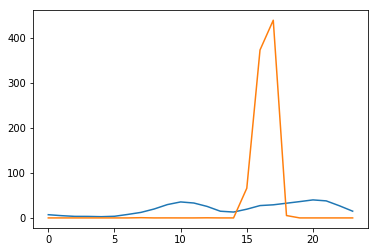

In [23]:
ax = pd.Series(stf_pred[0]['dw'][0][1]).plot()
pd.Series(test_gt[0]['dw'][0][1]).plot()

In [45]:
# calculate the error
stf_error = {}
for fold_num in range(5):
    stf_error[fold_num] = {}
    for idx, appliance in enumerate(APPLIANCE_ORDER[1:-1]):
        stf_error[fold_num][appliance] = onoff_error(stf_pred[fold_num][:, idx], 
                                                     test_gt[fold_num][appliance], threshold[appliance])

In [47]:
pd.DataFrame(stf_error)

,0,1,2,3,4
dr,257.359045,249.851932,248.456365,344.103572,319.657707
dw,112.494085,97.850823,357.493910,89.548906,121.215270
fridge,48.332191,53.300220,46.349932,54.892141,45.051758
hvac,332.491528,464.160965,427.902340,469.219663,450.743985
mw,16.473273,18.892953,15.944662,21.677814,23.451097
